### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [23]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [24]:
%matplotlib inline

In [7]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    return [C,K,theta]

In [8]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09
### add second layer parameters

In [9]:
# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [493]:
# make mesh variables
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

# Define ICs
case = 'slope'
if case == 'vertical':
    htop = -1
    hinit = -1000*np.ones(nz)
    hinit[0] = htop
elif case == 'slope':
    hinit = np.arange(nz)*-5
    
    
noflux = 0
if noflux == 1:
    hinit[0] = hinit[1] + dz

htop = hinit[0]
hbottom = hinit[-1]

In [496]:
fmtstr = 'h0={0}, dt={1:.0f} IC={2}'.format(htop, np.max(dts), case)  #add flux or no flux
printstr = 'h0={0} dt={1:.0f} IC={2}'.format(htop, np.max(dts), case)

if noflux == 1:
    fmtstr = 'no flux, dt={0:.0f} IC={1}'.format(np.max(dts), case)  #add flux or no flux
    printstr = 'no flux dt={0:.0f} IC={1}'.format(np.max(dts), case)
print fmtstr


h0=0, dt=10 IC=slope


In [497]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [498]:
# Define time variables
stop_tol = 1e-5  # Stopping tolerance [cm]
tmin = 0. # [s]

# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 


In [499]:
time_elapse = []
mass_balance = []
balance_w_err = []
total_fluxin = []
total_fluxout = []
total_newmass = []
total_error = []
total_iter = []
dts= [10**x for x in range(-2,2)]
stop_tol = 1e-5

for dt in dts:   
    tmax = 1000.
    t = np.arange(tmin, tmax + dt, dt)  #(tmin:dt:tmax);
    nt = len(t)
    
    H = np.zeros([nz,nt])
    K = np.zeros([nz,nt])
    C = np.zeros([nz,nt])
    H[:,0] = hinit; 
    K[:, 0] = Kinit; 
    C[:, 0] = Cinit

    THETA = np.zeros([nz,nt])
    THETA[:,0] = thetainit
    ktop = np.zeros([ nt])
    kbot = np.zeros([ nt])
    error = np.zeros([nt]) 
    error2 = np.zeros([nt]) 

    ktop[0] =  (K[0, 0] + K[1, 0])/2.  
    kbot[0] =  (K[-1, 0] + K[-2, 0])/2. 

    start_time = time.time()
    iterations = np.zeros([nt-1,1])
    for i in range(1, nt):      # Initialize the Picard iteration solver
        hnp1m =  H[:,i-1]  
        thetan = THETA[:,i-1]   
        stop_flag = 0
        niter = 0
        while(stop_flag==0): # Get C,K,theta
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
            Cdiag = np.diag(cnp1m)
            kbarplus = (1/2.)*MPlus.dot(knp1m)
            Kbarplus = np.diag(kbarplus)
            kbarminus = (1/2.)*MMinus.dot(knp1m)
            Kbarminus = np.diag(kbarminus)
            A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - \
                                              Kbarminus.dot(DeltaMinus))
            R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                                   Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
                (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan) 
            # Compute deltam for iteration level m+1
            deltam = np.linalg.pinv(A).dot(R_MPFD)
            # Increment iteration counter and display number of iterations
            niter = niter + 1
            if max(abs(deltam[1:(nz-1)]))<stop_tol:
                stop_flag = 1
                hnp1mp1 = hnp1m + deltam # Force boundary conditions       
                if noflux == 1:
                    hnp1mp1[0] = hnp1mp1[1] + dz
                else:
                    hnp1mp1[0] = htop  # boundary conditions    
                hnp1mp1[nz-1] = hnp1m[nz-2]
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi)
                thetanp1mp1 = thetanp1m
                knp1mp1 = knp1m
                cnp1mp1 = cnp1m            
                hnp1m = hnp1mp1
            else:
                hnp1mp1 = hnp1m + deltam
                hnp1m = hnp1mp1; # Force boundary conditions
                if noflux == 1:
                    hnp1m[0] = hnp1m[1] + dz
                else:
                    hnp1m[0] = htop
                hnp1m[nz-1] = hnp1m[nz-2]
        # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
        THETA[:,i] = thetanp1mp1
        H[:,i] = hnp1mp1
        K[:, i]= knp1mp1
        C[:, i] = cnp1mp1
        ktop[i] =  (K[0, i] + K[1, i])/2.  
        kbot[i] =  (K[-1, i] + K[-2, i])/2.   #(knp1mp1[-1] + knp1mp1[-2])/2.  
        error[i] = np.sum(A.dot(deltam))*dt
        error2[i] = dz*np.sum(C[:,i]*deltam[:]) -  kbot[i]*(deltam[-1] - \
                    deltam[-2])*dt/dz + ktop[i]*(deltam[1] - deltam[0])*dt/dz
        iterations[i-1] = niter
    fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux
    fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt  # bottom flux
    newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 
    
    time_elapse.append(time.time() - start_time)
    mass_balance.append(np.cumsum(fluxin[1:] - newmass + fluxout[1:])[-1])
    balance_w_err.append(np.cumsum(fluxin[1:] - newmass + fluxout[1:] - \
                                   error[1:])[-1])
    total_fluxin.append(np.cumsum(fluxin[1:] )[-1])
    total_newmass.append(np.cumsum(newmass )[-1])
    total_fluxout.append(np.cumsum(fluxout[1:] )[-1])
    total_error.append(np.cumsum(error[1:])[-1])
    total_iter.append(iterations)

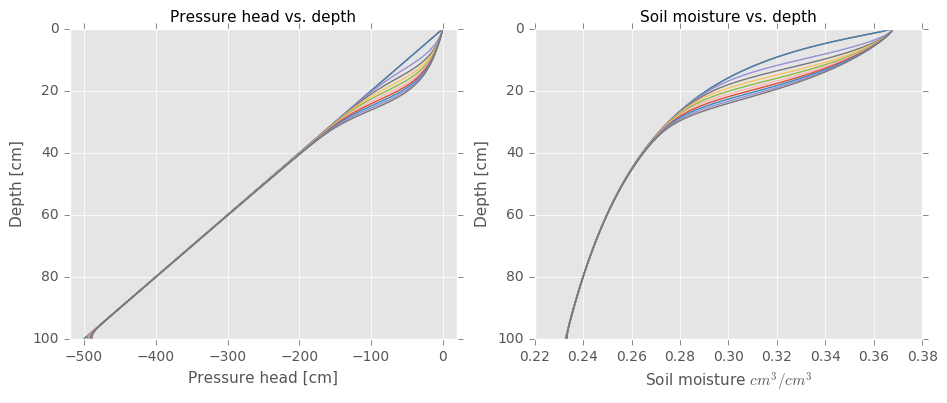

In [500]:
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.plot(hinit,z);
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.ylim(100, 0)
plt.gca().invert_yaxis()
plt.title('Pressure head vs. depth', fontsize=  11)
plt.ylim(100, 0)
ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.gca().invert_yaxis()
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(10):
    ax = plt.subplot(121)
    plt.plot(H[:, i],z)
    ax = plt.subplot(122)
    plt.plot(THETA[:, i],z)

fig.savefig('vary_tstep/profile {0}.pdf'.format(printstr))

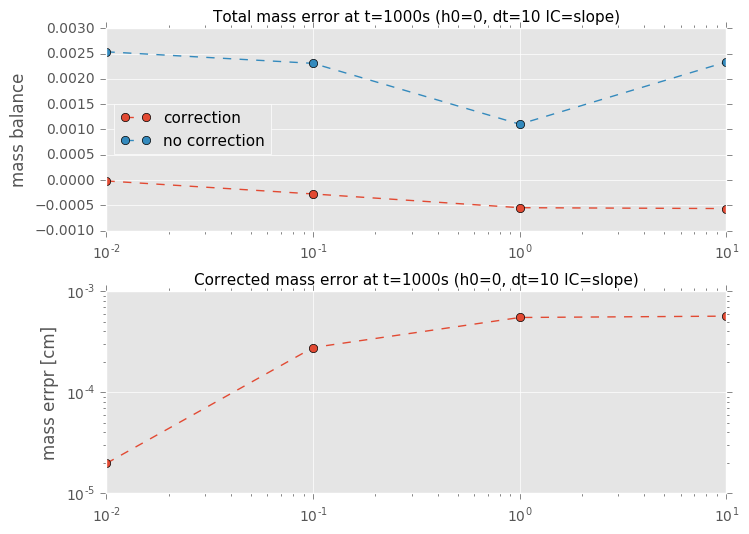

In [501]:
fig = plt.figure(figsize= (8,6))
fig.subplots_adjust(hspace = .3)
plt.subplot(211)
plt.semilogx(dts[:],balance_w_err[:], 'o--', label =  'correction')
plt.semilogx(dts, np.abs(np.array(mass_balance)), 'o--', label = 'no correction')
plt.ylabel("mass balance")
plt.title('Total mass error at t={1}s ({0})'.format(fmtstr, int(tmax)), fontsize = 11)
plt.legend(loc = 'best', fontsize = 11)

plt.subplot(212)

plt.loglog(dts,np.abs(balance_w_err), 'o--', label =  'correction')
plt.ylabel("mass errpr [cm]")
plt.title('Corrected mass error at t={1}s ({0})'.format(fmtstr, int(tmax)), fontsize = 11)
# plt.legend(loc = 'best', fontsize = 11)


fig.savefig('vary_tstep/mass balance {0}.pdf'.format(printstr))

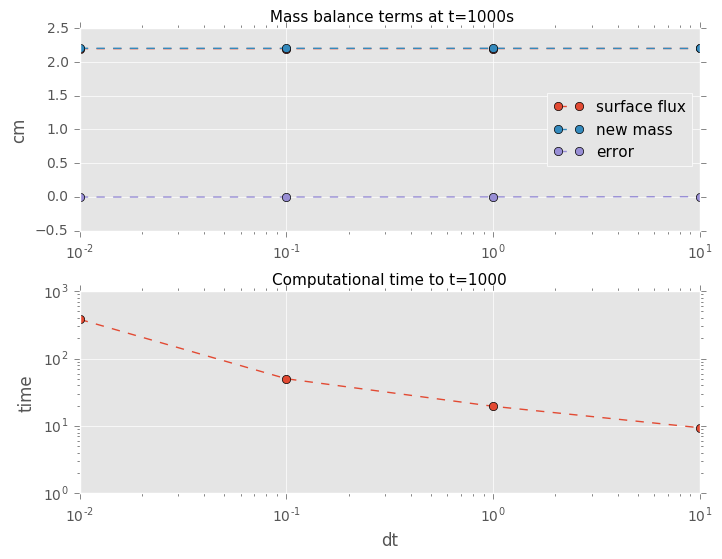

In [502]:
fig = plt.figure(figsize= (8,6))
fig.subplots_adjust(hspace = .3)
plt.subplot(211)

plt.semilogx(dts[:], np.array(total_fluxin), 'o--', label ='surface flux')
plt.semilogx(dts[:], np.array(total_newmass), 'o--',  label ='new mass')
plt.semilogx(dts[:], np.array(total_error), 'o--',  label ='error')
plt.ylabel("cm")
plt.title(' Mass balance terms at t={0}s'.format(int(tmax)), fontsize = 11)

plt.legend(loc = 'best', fontsize = 11)


plt.subplot(212)
nsteps = tmax/np.array(dts)
plt.loglog(dts, time_elapse, 'o--')
plt.ylabel("time")
plt.title('Computational time to t={0}'.format(int(tmax)), fontsize = 11)
plt.xlabel("dt")
fig.savefig('vary_tstep/time elapse {0}.pdf'.format(printstr))

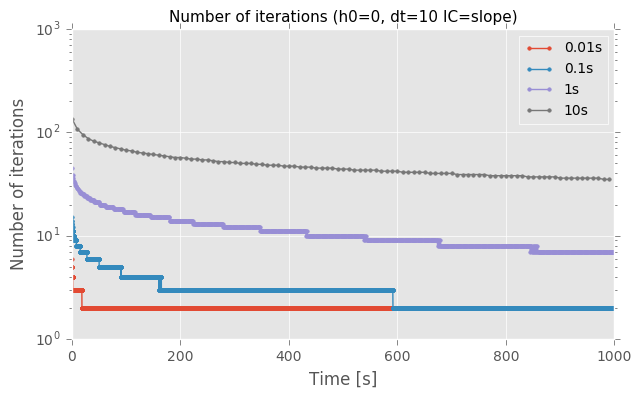

In [503]:
fig = plt.figure(1, figsize = (7,4))
for i in range(4):
    t = np.arange(tmin, tmax + dts[i], dts[i])
    plt.semilogy(t[:-1], total_iter[i], '.-', ms = 5, label = '{0}s'.format(dts[i]))
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('Time [s]');
plt.ylabel('Number of iterations')
plt.title('Number of iterations ({})'.format(fmtstr), fontsize = 11)
# fig.savefig('vary_tstep/iterations {0}.pdf'.format(printstr))

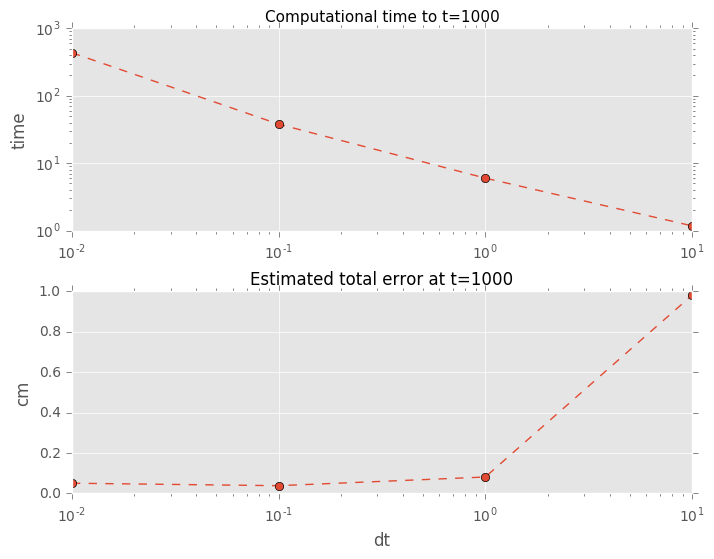

In [490]:
fig = plt.figure(figsize= (8,6))
fig.subplots_adjust(hspace = .3)
plt.subplot(211)
nsteps = tmax/np.array(dts)
plt.loglog(dts, time_elapse, 'o--')
plt.ylabel("time")
plt.title('Computational time to t={0}'.format(int(tmax)), fontsize = 11)

plt.subplot(212)
plt.semilogx(dts, np.abs(np.array(total_error)), 'o--')
plt.ylabel("cm")
plt.xlabel("dt")
plt.title('Estimated total error at t={0}'.format(int(tmax)), fontsize = 12)

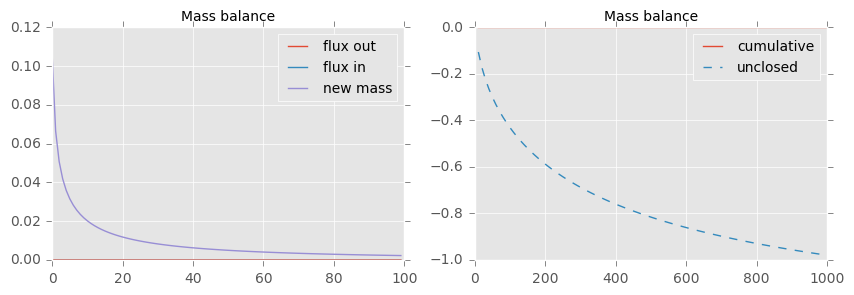

In [491]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
# plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:] - error[1:],  label = 'time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] ), label =  'cumulative')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] ), '--', label =  'unclosed')
plt.legend(fontsize = 10, loc= 'best')


In [492]:
for dt in dts:    
    t = np.arange(tmin, tmax + dt, dt)  #(tmin:dt:tmax);
    print t[-1]

1000.0
1000.0
1000.0
1000.0
